In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.dates as mdates

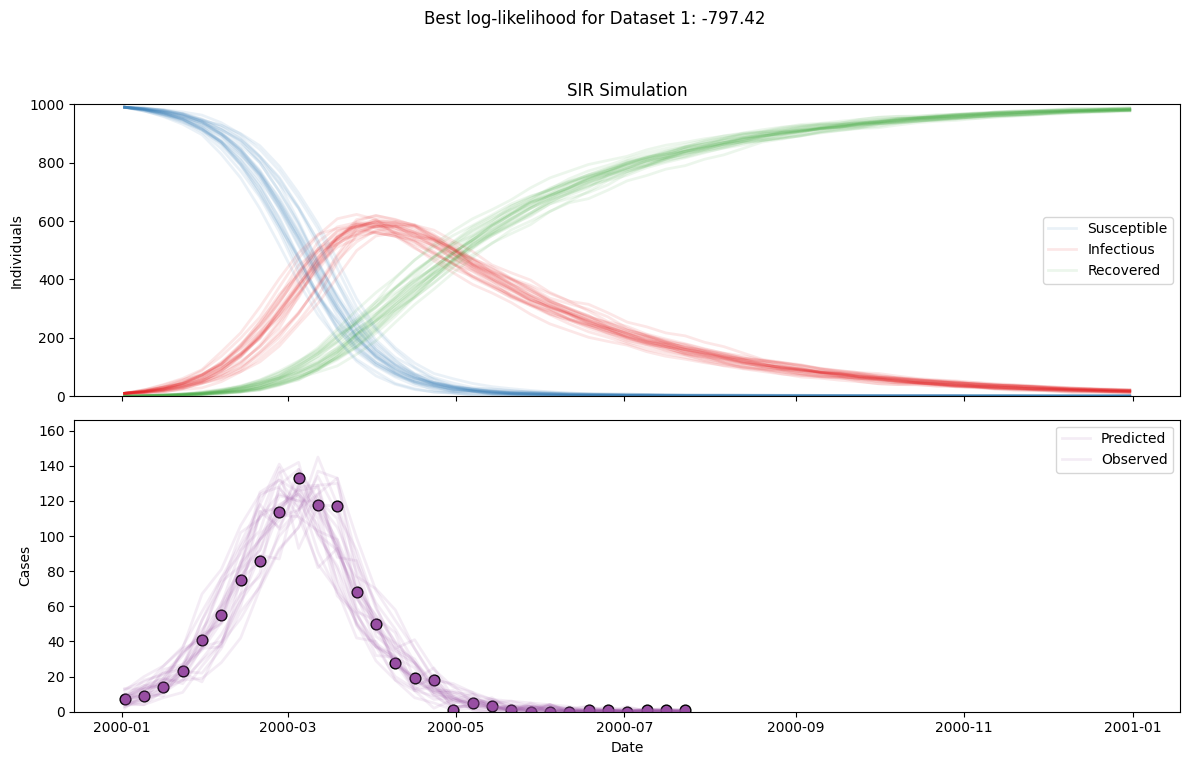

In [15]:
# --- Constants ---
Population = 1000
NumYears = 1
Year_start = 2000
Year_end = Year_start + NumYears - 1
Date_start = pd.to_datetime(f"{Year_start}-01-01")
Date_end = pd.to_datetime(f"{Year_end}-12-31")
time_step = "1 week"
Dates = pd.date_range(start=Date_start, end=Date_end, freq="W")

if time_step == "1 year":
    dt = 1
elif time_step == "1 month":
    dt = 1/12
elif time_step == "1 week":
    dt = 1/52
else:
    dt = 1/365

def beta(date, par):
    return par

def run_SIR(pars):
    SIROut = np.zeros((len(Dates) + 1, 6))
    SIROut[0, 0] = pars[0]  # S
    SIROut[0, 1] = pars[4]  # I
    SIROut[0, 2] = Population - SIROut[0, 0] - SIROut[0, 1]  # R

    beta_val = pars[1]
    gamma = pars[2]
    rho = pars[3]

    for d_num in range(len(Dates)):
        current_S = SIROut[d_num, 0]
        current_I = SIROut[d_num, 1]
        current_R = SIROut[d_num, 2]
        current_N = current_S + current_I + current_R

        p_inf = 1 - np.exp(-beta_val * (current_I / current_N) * dt)
        p_rec = 1 - np.exp(-gamma * dt)

        new_infections = np.random.binomial(n=int(current_S), p=p_inf)
        new_recovered = np.random.binomial(n=int(current_I), p=p_rec)
        new_cases = np.random.binomial(n=new_infections, p=rho)

        SIROut[d_num + 1, 0] = current_S - new_infections
        SIROut[d_num + 1, 1] = current_I + new_infections - new_recovered
        SIROut[d_num + 1, 2] = current_R + new_recovered
        SIROut[d_num, 3] = new_infections
        SIROut[d_num, 4] = new_recovered
        SIROut[d_num, 5] = new_cases

    return SIROut[:-1]  # drop last row

def error(pars, obs_data, max_attempts=5):
    attempt = 0
    valid_ll = False

    while attempt < max_attempts and not valid_ll:
        attempt += 1
        guess_out = run_SIR(pars)
        S = guess_out[:, 0]
        I = guess_out[:, 1]
        N = guess_out[:, 0:3].sum(axis=1)
        p_inf = 1 - np.exp(-pars[2] * I / N * dt)
        p_case = p_inf * pars[3]

        if np.all(S >= obs_data):
            log_lik = np.sum(np.log(np.maximum(np.random.binomial(n=S.astype(int), p=p_case), 1e-10)))
            valid_ll = True

    if not valid_ll:
        log_lik = -1e20

    return log_lik

# --- Example Plot ---
from matplotlib import colormaps

base_colors = colormaps.get_cmap('Set1').colors[:4]
translucent_colors = [to_rgba(c, alpha=0.1) for c in base_colors]

n_draws = 25
best_guess_pars = [990, 365/10, 365/70, 1, 10]
draw_results = [run_SIR(best_guess_pars) for _ in range(n_draws)]

obs_data = draw_results[0][:, 5]
best_ll = error(best_guess_pars, obs_data)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].set_ylim(0, Population)
axs[0].set_ylabel("Individuals")
axs[0].set_title("SIR Simulation")

for result in draw_results:
    axs[0].plot(Dates, result[:, 0], color=translucent_colors[1], lw=2)  # Susceptible
    axs[0].plot(Dates, result[:, 1], color=translucent_colors[0], lw=2)  # Infectious
    axs[0].plot(Dates, result[:, 2], color=translucent_colors[2], lw=2)  # Recovered

axs[0].legend(["Susceptible", "Infectious", "Recovered"], loc='right')

XMAX = np.max(np.where(obs_data > 0)) + 1

axs[1].set_ylim(0, 1.25 * np.max(obs_data))
axs[1].set_ylabel("Cases")
axs[1].set_xlabel("Date")

for result in draw_results:
    axs[1].plot(Dates[:XMAX], result[:XMAX, 5], color=translucent_colors[3], lw=2)

axs[1].scatter(Dates[:XMAX], obs_data[:XMAX], s=60, marker='o', color=base_colors[3], edgecolor='black', label="Observed")
axs[1].legend(["Predicted", "Observed"], loc='upper right')

plt.suptitle(f"Best log-likelihood for Dataset 1: {best_ll:.2f}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()